#### TP2 - Black Friday

In [1]:
# load libs for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("BlackFriday.csv")
data.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


##### Q1 - Dado o padrão de consumo dos compradores, é possível inferir o gênero?

Vamos começar analisando a quantidade de usuários, produtos.

In [3]:
## Quantos usuários e produtos existem na base ?
print "Usuários", len(np.unique(data.User_ID))
print "Produtos", len(np.unique(data.Product_ID))

Usuários 5891
Produtos 3623


Agora vamos analisar quantos desses usuários são homens ou mulheres, e para isso, precisamos remover um mesmo usuário.

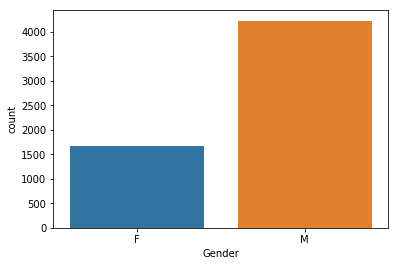

In [4]:
MF = data.drop_duplicates('User_ID') # count just one time
MF.head(10)
sns.countplot(x="Gender", data=MF)

Esse resultado já chama nossa atenção para um problema de desbalanceamento entre classes. Vamos analisar agora a quantidade de compras por Gênero:

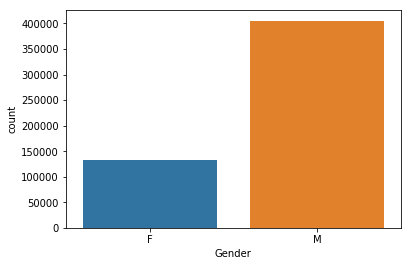

In [5]:
sns.countplot(x="Gender", data=data)

Quais são os produtos mais comprados pelas mulheres e pelos homens ?

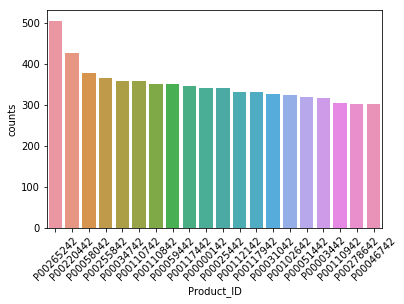

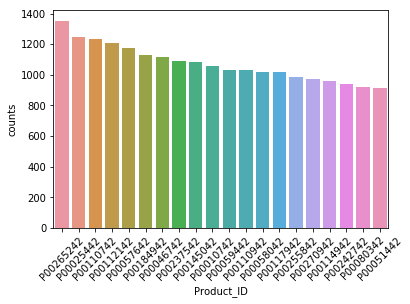

In [6]:
prod = data.groupby(["Product_ID","Gender"]).size().reset_index(name='counts')
F = prod[prod.Gender=='F'][['Product_ID','counts']].sort_values(by='counts',ascending=False).iloc[0:20]
M = prod[prod.Gender=='M'][['Product_ID','counts']].sort_values(by='counts',ascending=False).iloc[0:20]


chart = sns.barplot(x="Product_ID",y="counts",data=F)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.show()
chart = sns.barplot(x="Product_ID",y="counts",data=M)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

F = prod[prod.Gender=='F'][['Product_ID','counts']].sort_values(by='counts',ascending=False)
M = prod[prod.Gender=='M'][['Product_ID','counts']].sort_values(by='counts',ascending=False)


Pelo Gráfico, podemos notar que o produto mais comprado aparece tanto nas listas de mulheres e homens, além disso, o segundo produto mais comprado  tanto na lista de homens e mulheres são exclusivos. Um outro fato importante a ser notado é justamente o volume de transações, o grupo masculino apresenta quase o dobro de compras que o volume feminino.

Agora vamos analisar a quantidade de produtos que aparecem somente no grupo feminino

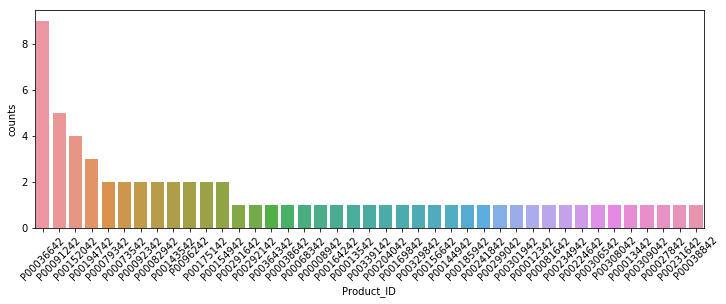

In [7]:
plt.figure(figsize=(12,4))
onlyF = F[~F.Product_ID.isin(M.Product_ID)]
chart = sns.barplot(x="Product_ID",y="counts",data=onlyF)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);


As mulheres possuem apenas 42 produtos únicos, além disso, eles não aparecem em grandes quantidades. Agora, vamos analisar se alguma feature possui algum comportamento predominante de homem ou mulher.

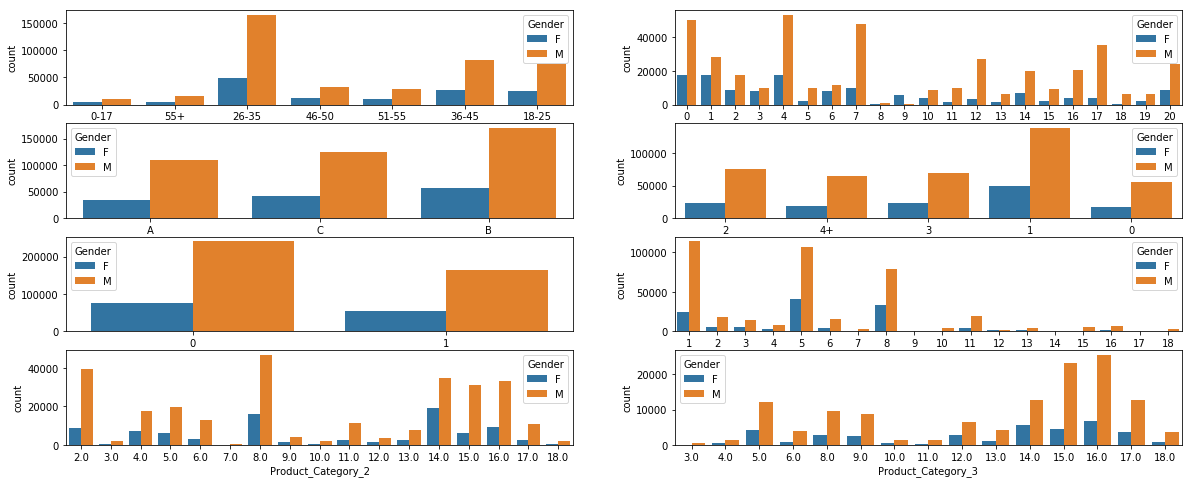

In [8]:
#City_Category 	Stay_In_Current_City_Years 	Marital_Status 	Product_Category_1 	Product_Category_2 	Product_Category_3
plt.figure(figsize=(20,8))
#fig, ax = plt.subplots(nrows=3, ncols=2)
for i,feat in enumerate(['Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status'\
             ,'Product_Category_1','Product_Category_2','Product_Category_3']):
    
    if feat == 'Gender' or feat == 'User_ID':
        
        continue
        
    plt.subplot(4, 2, i+1)
    sns.countplot(x=feat,hue="Gender",data=data)
#plt.show()


Pelos gráficos podemos notar que as features relacionadas com a categoria do produto apresentam valores de consumo mais discrepantes entre homens e mulheres

Dado as relações produtos Vs gênero e produto Vs usuários vamos criar features baseadas em filtragem colaborativa. Vamos começar mapeando a relação produto Vs gênero usar uma técnica de kernel para ganharmos representações latentes, e agregar essa informações nos nossos dados:

In [9]:
graph = np.zeros([3623,2])

mapsProduct = {}
cont = 0 
mapsG = {'M':0,'F':1}
for row in prod.values:
    
    if row[0] not in mapsProduct:
        
        mapsProduct[row[0]] = cont
        cont += 1
        
    graph[mapsProduct[row[0]]][mapsG[row[1]]] += row[2]
    
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA

transformer = KernelPCA(n_components=5, kernel='cosine')
KernelPCA = transformer.fit_transform(graph)

unFeatures = pd.DataFrame()

for feat in range(0,5):
    
    unFeatures['PCA_'+str(feat)] = KernelPCA[:,feat]
    
unFeatures['Product_ID'] = prod['Product_ID']

dataN = data.merge(unFeatures,on='Product_ID')


Agora vamos mapear a relação user vs product e reduzir a dimensionalidade usando mais uma vez a técnica kernel pca, e agregar essa informação nos nossos dados:

In [10]:
users = data.groupby(["Product_ID","User_ID"]).size().reset_index(name='counts').sort_values(by='counts',ascending=False)

graph = np.zeros([3623,5891])

mapsProduct = {}
cont = 0 
contU = 0
mapsUser = {}

for row in prod.values:
    
    if row[0] not in mapsProduct:
        
        mapsProduct[row[0]] = cont
        cont += 1
    
    if row[1] not in mapsUser:
        
        mapsUser[row[1]] = contU
        contU += 1
        
    graph[mapsProduct[row[0]]][mapsUser[row[1]]] += row[2]
    
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA

transformer = KernelPCA(n_components=30, kernel='cosine')
KernelPCA = transformer.fit_transform(graph)

unFeatures = pd.DataFrame()

for feat in range(0,15):
    
    unFeatures['P_PCA_'+str(feat)] = KernelPCA[:,feat]
    
unFeatures['Product_ID'] = prod['Product_ID']

dataF = dataN.merge(unFeatures,on='Product_ID')

Vamos agora tratar as features categoricas para poderem serem classificadas 

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

dataF[['User_ID','Product_ID','Age','Gender','City_Category','Stay_In_Current_City_Years']] = dataF[['User_ID','Product_ID','Age','Gender','City_Category','Stay_In_Current_City_Years']].apply(le.fit_transform)

Vamos agora dividir os dados e classifica-los

In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split


dataFi = dataF.fillna(-1)
y = dataFi.Gender
dataFi = dataFi.drop(['Gender'],axis=1)
X = dataFi.values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

d_train = lgb.Dataset(X_train, label= y_train)

params = {}
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'

clf= lgb.train(params, d_train, 100)

y_pred = clf.predict(X_test)

for i in range(0,len(y_test)):
    if (y_pred[i] >= 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] =0
        

print f1_score(y_test,y_pred),precision_score(y_test,y_pred),recall_score(y_test,y_pred)


0.9148194687138004 0.8468904304625731 0.9945959599553161


Como temos um problema de desbalanceamento entre as classe, a métrica F1 foi escolhida justamente com o precision e recall para avaliar o desempenho do modelo. Dessa forma, um modelo simples, com a adição de features latentes, conseguiu atingir 90% de F1 score.

##### Q2 - Dado as informações de consumo dos compradores, é possível inferir qual o gasto?

Vamos utilizar o mesmo modelo anterior, porém, agora temos um problema de regressão

In [14]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100,np.var(np.abs((y_true - y_pred) / y_true)) * 100,\
np.std(np.abs((y_true - y_pred) / y_true)) * 100


lgbm = LGBMRegressor(verbosity=0,verbose_eval=0,silent=0,verbose=-1)


dataFi = dataF.fillna(-1)
y = np.log(dataFi.Purchase.astype(float))
dataFi = dataFi.drop(['Purchase'],axis=1)
X = dataFi.values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


lgbm = LGBMRegressor(verbosity=0,verbose_eval=0,silent=0,verbose=-1)
lgbm.fit(X_train,y_train)
preds = lgbm.predict(X_test)


print "(MAPE,VAR,STD)",mean_absolute_percentage_error(y_test,preds)
print mean_squared_error(y_test,preds)
print mean_absolute_error(y_test,preds)

(MAPE,VAR,STD) (3.554589359569635, 0.12750680788037433, 3.5708095423919533)
0.16668828596024704
0.3075807000381673


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Agora no problema de regressão atingimos um MAPE em torno de 3% com variancia proximo de 0.12%!

##### Q3 - A média de compra de cada faixa etária é representativa? Ou possui muitos outliers?

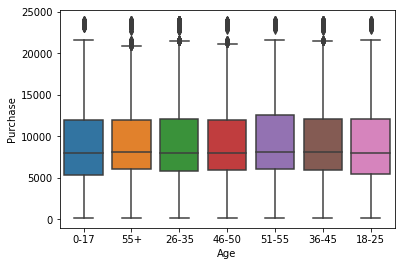

In [15]:
sns.boxplot(y='Purchase',x='Age',data=data)

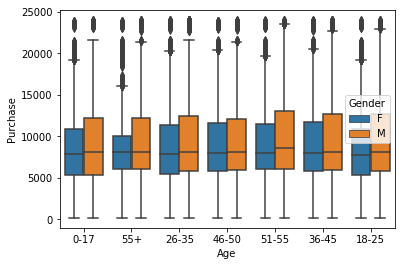

In [16]:
sns.boxplot(y='Purchase',x='Age',data=data,hue='Gender')

Todos os grupos apresentam uma média de compra bastante similar com muitos outliers. Mesmo com a subdivisão por gênero, podemos notar bastante outliers e grupos com perfis muito similares.  

##### A partir dos dados disponíveis, é possível agrupar os compradores de forma a identificar um padrão de consumo por faixa etária?

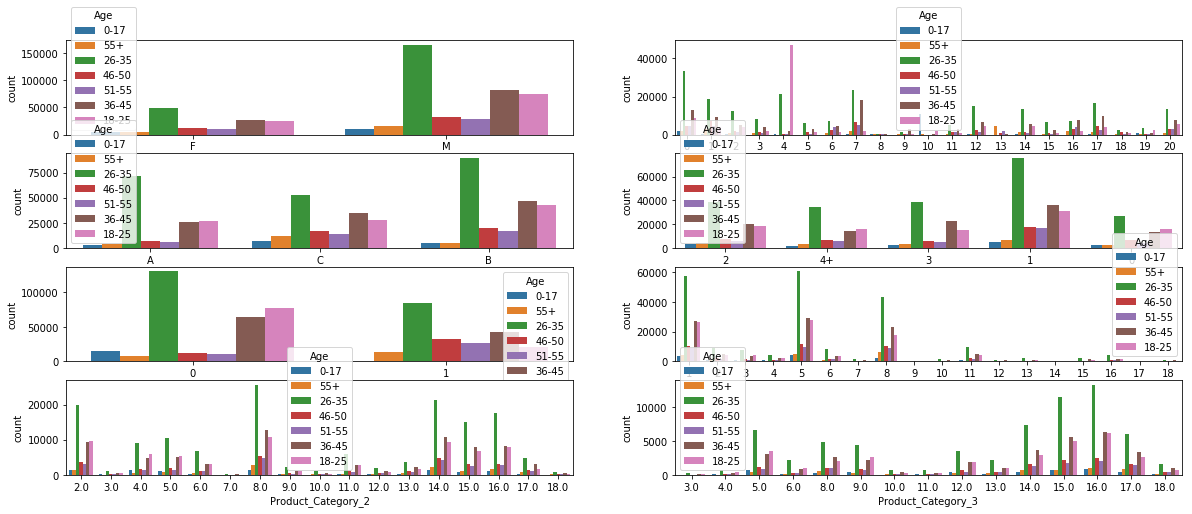

In [17]:
#City_Category 	Stay_In_Current_City_Years 	Marital_Status 	Product_Category_1 	Product_Category_2 	Product_Category_3
plt.figure(figsize=(20,8))
#fig, ax = plt.subplots(nrows=3, ncols=2)
for i,feat in enumerate(['Gender','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status'\
             ,'Product_Category_1','Product_Category_2','Product_Category_3']):
    
    if feat == 'User_ID':
        
        continue
        
    plt.subplot(4, 2, i+1)
    sns.countplot(x=feat,hue="Age",data=data)
#plt.show()

Tentei aigrupar usando uma técnica de cluster, mas não consegui identificar os grupos ... 